Once deleted, variables cannot be recovered. Proceed (y/[n])? y


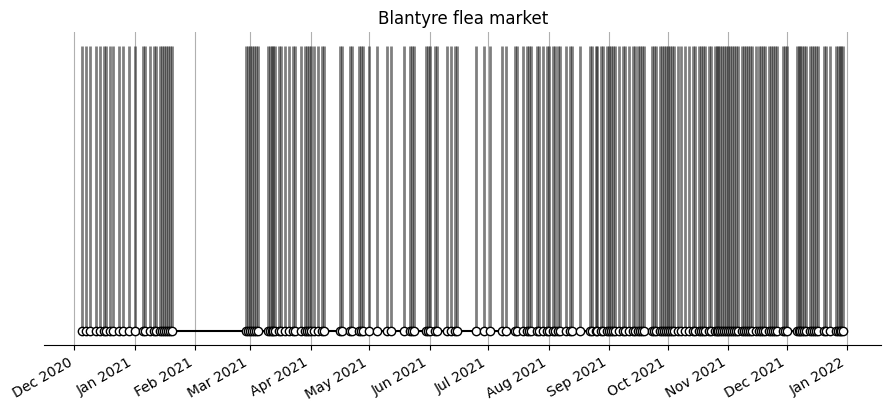

0


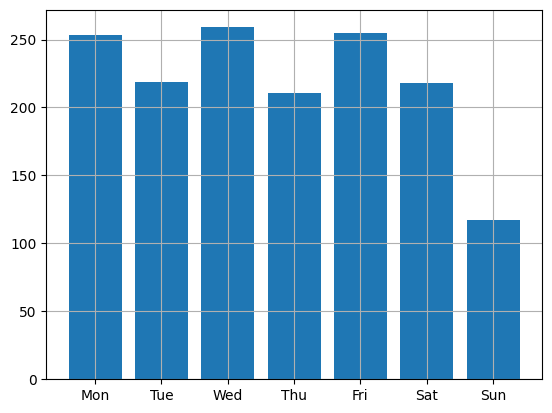

In [291]:
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

numBin = 0

#Dump events
dump_arrival = pd.read_csv('../../data/raw_data/03_Skip_deliveries_at_Mzedi.csv')
dump_arrival = dump_arrival.drop(columns=['end','deviceid', 'start'])

#List of origin points
list_origin = dump_arrival.skip_origin.unique().astype(str)
list_origin = list_origin[list_origin!= 'nan']

#Datetime conversion and sorting
dump_arrival.date = pd.to_datetime(dump_arrival.date)#.dt.tz_localize('Africa/Mbabane')
dump_arrival = dump_arrival.sort_values('date')


## PIVOT TABLE
dump_arrival_new = dump_arrival.copy()
#dump_arrival_new['month'] = dump_arrival_new['date'].dt.month
#dump_arrival_new['year'] = dump_arrival_new['date'].dt.year
dump_arrival_new['values'] = 1
#print(dump_arrival_new)
new_pivot = pd.pivot_table(dump_arrival_new,values='values',index=['date'],columns='skip_origin',aggfunc=np.sum, fill_value=0)



## TIMELINE PLOT
#dates_arrival_skip = dump_arrival.loc[dump_arrival.skip_origin == list_origin[numBin]].sort_values('date').date
#print(dates_arrival_skip)
#print(len(dates_arrival_skip))
dates_arrival_skip = new_pivot[new_pivot[list_origin[numBin]]!=0].index
#plot timeline of dump arrivals from destination
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
levels = np.tile([1,1], int(np.ceil(len(dates_arrival_skip)/2)))[:len(dates_arrival_skip)] #+1,-1 stems
ax.vlines(dates_arrival_skip, 0, levels, linestyle='solid', color=[(0, 0, 0, 0.5)], linewidth=2)  # The vertical stems
ax.plot(dates_arrival_skip, np.zeros_like(dates_arrival_skip), "-o", color="k", markerfacecolor="w")  #Tick plot
ax.yaxis.set_visible(False) #Hide y axis
ax.spines[["left", "top", "right"]].set_visible(False)#Hide other lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) #Month interval labels
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.grid(True)
plt.title(list_origin[numBin])
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show() #Plot


#Period start !!still change so that a different period time for each skip
time_start = pd.to_datetime('2021-10-01')
time_end = pd.to_datetime('2021-09-01')


#Individual skip analysis: timeline, average, max, min, pattern <-- for specific periods to match skip raw data periods

## !!ADD VARIABILITY (HISTOGRAM, VARIANCE) AS A MEASURE OF REGULARITY
## interquartile range (IQR) instead of the variance to account for outliers
##  Five Number Summary
## OR AUTOREGRESSIVE MODEL <-- nah

#start,end,min, max, mean, median, mode
#period_start,period_end,min_period,max_period,median_period,mode_period

skip_data = pd.DataFrame(np.zeros([len(list_origin),16]),columns=['start','end','#','min','max','mean','median','mode','period_start','period_end','#_period','min_period','max_period','mean_period','median_period','mode_period'], index=list_origin)
for columns in list_origin: #new_pivot
    current_skip = new_pivot[columns][new_pivot[columns]!=0]
    diff_0 = (current_skip[current_skip>1]-1).sum()
    current_skip_index_diff = current_skip.index.to_series().diff().dt.days.dropna().tolist()
    listofzeros = [0] * diff_0
    current_skip_index_diff.extend(listofzeros)
    skip_data.loc[columns,'start'] = current_skip.index.to_series().min()
    skip_data.loc[columns,'end'] = current_skip.index.to_series().max()
    skip_data.loc[columns,'#'] = len(current_skip)
    skip_data.loc[columns,'min'] = min(current_skip_index_diff)
    skip_data.loc[columns,'max'] = max(current_skip_index_diff)
    skip_data.loc[columns,'mean'] = statistics.mean(current_skip_index_diff)
    skip_data.loc[columns,'median'] = statistics.median(current_skip_index_diff)
    skip_data.loc[columns,'mode'] = statistics.mode(current_skip_index_diff)

    
    current_skip_period = current_skip[(current_skip.index >= time_start) & (current_skip.index <= time_end)]
    diff_0_period = (current_skip_period[current_skip_period>1]-1).sum()
    current_skip_period_index_diff = current_skip_period.index.to_series().diff().dt.days.dropna().tolist()
    listofzeros_period = [0] * diff_0_period
    current_skip_period_index_diff.extend(listofzeros_period)
    if(current_skip_period_index_diff):
        skip_data.loc[columns,'period_start'] = current_skip_period.index.to_series().min()
        skip_data.loc[columns,'period_end'] = current_skip_period.index.to_series().max()
        skip_data.loc[columns,'#_period'] = len(current_skip_period)
        skip_data.loc[columns,'min_period'] = min(current_skip_period_index_diff)
        skip_data.loc[columns,'max_period'] = max(current_skip_period_index_diff)
        skip_data.loc[columns,'mean_period'] = statistics.mean(current_skip_period_index_diff)
        skip_data.loc[columns,'median_period'] = statistics.median(current_skip_period_index_diff)
        skip_data.loc[columns,'mode_period'] = statistics.mode(current_skip_period_index_diff)
        #print('not empty')
        
#Dump analysis: bar plot, pattern (week), average per week
#Correlation between day of week and incoming skip origin?
#Day of week:
list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
new_list=[]
new_new_list=[]
for i in range(len(dump_arrival.date.dt.dayofweek.to_list())):
    new_list.append(list_days[dump_arrival.date.dt.dayofweek.to_list()[i]])
for j in list_days:
    new_new_list.append(new_list.count(j))
    
fig, ax = plt.subplots()
ax.bar(list_days, new_new_list)
ax.grid()


#Month
